For the final project, I'll analyze the CoffeeKing dataset (Yelp Academic Dataset), to see if there's anything interesting we can dig out.  
Here's the discription:  
CoffeeKing is a new startup coffee company providing a unique and novel experience to their customers.  They want to appeal to a wide variety of clientele.  You will use Yelp reviews and user data to provide insights to CoffeeKing for things such as location selection and/or hours of operation (and other questions?)  
  
### First, import the packages we needed to do EDA.

In [1]:
# Packages for data process
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib
import matplotlib.pyplot as plt
import scipy
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_columns', None)  

C:\Users\user\AppData\Local\Temp/ipykernel_13212/3038518209.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


In [ ]:
# Visualize setting
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [2]:
# Packages for NLP
import ast
import spacy
# spacy.cli.download("en_core_web_sm")
spacy.load('en_core_web_sm')
from spacy.lang.en import English
import nltk
# nltk.download('wordnet')
from nltk import pos_tag
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('stopwords')
from gensim import corpora
import pickle
import gensim
import pyLDAvis
from pyLDAvis import gensim_models

In [3]:
import importlib
import util
importlib.reload(util)
from util import *

In [ ]:
# Load data
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'
yelp_coffee_filtered = pd.read_pickle(json_path + '/yelp_coffee_topic.pkl')

Check for data's basic information.

In [102]:
# Check for total size
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'

print('size of store: ', count_total_rows(json_path, 'yelp_academic_dataset_business.json', 100000))
print('size of review: ', count_total_rows(json_path, 'yelp_academic_dataset_review.json', 100000))
print('size of user: ', count_total_rows(json_path, 'yelp_academic_dataset_user.json', 100000))

size of store:  160585
size of review:  8635403
size of user:  2189457


In [152]:
# Find stores selling coffee
yelp_bs = pd.read_json(json_path + 'yelp_academic_dataset_business.json', lines=True)
yelp_bs['categories'] = yelp_bs['categories'].map(lambda x: to_lower_case(x))
yelp_bs = yelp_bs[yelp_bs['categories'].str.contains('coffee').map(lambda x: True if x is True else False)] # Find store category with "coffee"
coffee_id = list(yelp_bs['business_id'])

In [154]:
# Deal with review, append reviews of the coffee stores
coffee_review = []
with open(json_path + "yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(json_path + "yelp_academic_dataset_review.json", 
                        lines=True, chunksize=100000)
    for chunk in reader:
        chunk = chunk[chunk['business_id'].isin(coffee_id)]
        coffee_review.append(chunk)
f.close()

In [155]:
yelp_rv = pd.concat(coffee_review, ignore_index=True)
user_id = yelp_rv['user_id'].unique().tolist()

In [156]:
# Search for user information
user_info = []
with open(json_path + "yelp_academic_dataset_user.json", "r") as f:
    reader = pd.read_json(json_path + "yelp_academic_dataset_user.json", 
                        lines=True, chunksize=100000)
    for chunk in reader:
        chunk = chunk[chunk['user_id'].isin(user_id)]
        user_info.append(chunk)
f.close()

In [157]:
yelp_user = pd.concat(user_info, ignore_index=True)

In [158]:
# Drop columns we don't need
yelp_bs.drop(["address", "postal_code", "latitude", "longitude"], axis=1, inplace=True)
yelp_rv.drop(["review_id"], axis=1, inplace=True)
yelp_user.drop(["name", "friends"], axis=1, inplace=True)

In [159]:
# Change column names that may duplicated
yelp_bs.rename(columns={"stars":"store_stars", "review_count":"store_review_count"}, inplace=True)
yelp_rv.rename(columns={"stars":"rv_stars", "useful":"rv_useful", "funny":"rv_funny", "cool":"rv_cool"}, inplace=True)
yelp_user.rename(columns={"review_count":"user_review_count"}, inplace=True)

In [160]:
# Merge tables, base on review
yelp_coffee = pd.merge(pd.merge(yelp_rv, yelp_bs, on="business_id", how='left'), 
                        yelp_user, on="user_id", how='left')

In [162]:
# Save merged table
yelp_coffee.to_csv(json_path + 'yelp_coffee.csv')

In [161]:
# Brief descrive of our merged table
print('We have {} distinct coffee stores.'.format(yelp_coffee['business_id'].unique().shape[0]))
print('With {} reviews about those stores.'.format(yelp_coffee.shape[0]))
print('And {} distinct users comment on them.'.format(yelp_coffee['user_id'].unique().shape[0]))
print('Our merged table has {} rows and {} features.'.format(yelp_coffee.shape[0],yelp_coffee.shape[1]))

We have 7747 distinct coffee stores.
With 605303 reviews about those stores.
And 321890 distinct users comment on them.
Our merged table has 605303 rows and 36 features.


### Now we can start to find what's in our table.

In [10]:
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'
yelp_coffee = pd.read_csv(json_path + 'yelp_coffee_category.csv',index_col=0)
yelp_coffee

,user_id,business_id,rv_stars,rv_useful,rv_funny,rv_cool,text,date,name,city,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.,2018-03-03 23:45:25,Thierry,Vancouver,...,2,0,0,0,2,11,2,2,0,1
1,LV1ME-ibA2h0IGyFUUWhaQ,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.,2017-08-07 19:34:13,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
2,JuM-lH05m6Ln8OPUTg8p0g,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!",2016-09-18 17:06:01,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
3,4cDqW9sWnZ57tsIEiElJWw,0nMbLN0B5I-2tNnQLSo86w,5,4,4,4,"""Even the mad Captain Ahab is touched by Starbuck's goodness...""\n Herman Melville \n\nThe drive-thru was jammed with vehicles when I pulled up, so I opted to park and go to the walk-up window. \n\nThe staff were super friendly! More then a few of them said hello to me while I ordered. Even though they were busy, they were all genuinely smiling. They look like they enjoy their job. Great teamwork! \nI think this is the friendliest Starbucks I've ever visited. \n\nThe building is architecturally pleasing to me so it catches my eye every time I've driven past it. I'm glad I stopped this time.\n\nIt's close to my freeway entrance so I'll be making this a regular stop from now on. If you're in the area, you should too!",2017-12-02 19:41:59,Starbucks,Portland,...,16,0,3,0,82,224,237,237,66,75
4,7mWnNVk2n99JxkvV3PW0nA,Un6u2cECyV4nZb_HGZ-uTA,4,1,0,1,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!",2011-02-13 16:38:09,Tin Shed Garden Cafe,Portland,...,4,1,0,3,12,28,28,28,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605298,im-MIiI-UFJsdrmIaxer2A,edlA6hSakvNxRZQFbuf-Iw,3,0,0,0,"I've always gone to sharetea wherever I go for boba, and this place is by far my least favorite. For one, they told me they only do 100% or 80% even though the menu says otherwise. Also asked for almond milk substitute, but they used soy milk instead.\n\nOn the brighter side, they do give you a lot of boba in the drinks, and the workers were friendly.",2021-01-25 23:04:35,Sharetea,Beaverton,...,0,0,0,0,0,0,0,0,0,0
605299,Cs5isLcwZgK-Cd1SA4TShw,p4sp8NYrFW7MmBajumBrtg,1,1,0,0,Every time I come to this dunkin they don't give me the correct coffee or forget stuff from my order. Drive the extra miles for a different dunkin,2020-06-30 14:21:53,Dunkin',Dunwoody,...,0,0,0,0,0,0,0,0,0,0
605300,_ailSgaI-3ztQxRnZtcluw,3uyvi_du7-s

In [11]:
yelp_coffee.columns

Index(['user_id', 'business_id', 'rv_stars', 'rv_useful', 'rv_funny',
       'rv_cool', 'text', 'date', 'name', 'city', 'state', 'store_stars',
       'store_review_count', 'is_open', 'attributes', 'categories', 'hours',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'elite', 'fans', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

<AxesSubplot:>

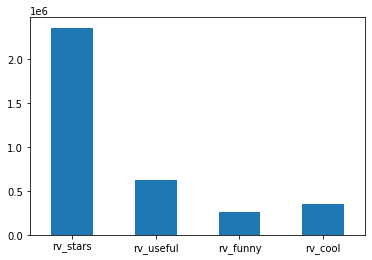

In [12]:
# Numbers of different types of reviews
yelp_coffee[['rv_stars', 'rv_useful', 'rv_funny', 'rv_cool']].sum().plot.bar(rot=0)

Looks like there's more "useful" review than the others.  
Since we got too many reviews and stores in our data, let's filter out with store_review_count.

(1411, 36)


<AxesSubplot:xlabel='store_review_count'>

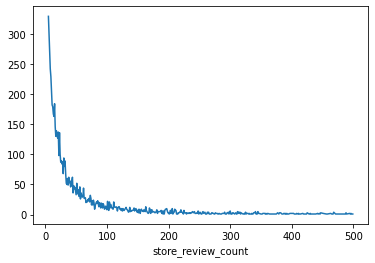

In [13]:
shop_filter = yelp_coffee.drop_duplicates('business_id').groupby('store_review_count')['business_id'].count()
print(yelp_coffee[yelp_coffee['store_review_count']>100].drop_duplicates('business_id').shape)
shop_filter[shop_filter.index<500].plot.line()

Looks like review_count 100 is a good point.  
And after filtering, we have 1411 stores remain.

In [14]:
yelp_coffee_filtered = yelp_coffee[yelp_coffee['store_review_count']>100]

In [15]:
yelp_coffee_filtered.columns

Index(['user_id', 'business_id', 'rv_stars', 'rv_useful', 'rv_funny',
       'rv_cool', 'text', 'date', 'name', 'city', 'state', 'store_stars',
       'store_review_count', 'is_open', 'attributes', 'categories', 'hours',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'elite', 'fans', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

In [16]:
yelp_coffee_filtered[['rv_stars','text']]

,rv_stars,text
0,1,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.
1,5,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.
2,5,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!"
4,4,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!"
5,4,"5 stars for the location, it's absolutely wonderful. I ordered the shamrock bubble tea, which was one of the best I've ever had. I am subtracting a star for service however. It was the barista that was so put out by waiting on us and then the 10-15 minutes it took to make the bubble tea... That's a bit long for a drink."
...,...,...
605295,5,"Ever since I returned from Australia, I wondered why restaurants here didn't go above and beyond on food presentation the way that the Aussies did. Edible Flowers, gorgeous dishes, beautiful bright and colorful layers stacked high, etc. was just not a thing in Portland. There is something about it that makes the dining experience just a bit more pleasant, and as soon as I heard about Proud Mary, I felt those same nostalgic Australian vibes. Turns out, Proud Mary is from Melbourne, and everything made sense.\n\nI got to hear beautiful accents all around me, eat my Vegemite on toast, drink delicious coffee, sit in a gorgeous restaurant, and eat beautiful food. I got to escape for a bit, and I felt like I was back on the other side of the world. \n\nI'm still waiting for the edible floral and fruit stacked pancakes that I have yet to find in America, but I will wait. I know they'll come. As for what I did have, delicious. I am praying for more and more vegan items to show up on the menu, but I like the options we've been given thus far. \n\nGood on ya"
605296,4,"It's a super solid coffee shop. You could tell how good their coffee is just by the amount of people waiting in line at 9 in the morning, and there aren't any other places nearby that are worth stopping by either. The inside is very unique and gives a slightly ""rugged"" vibe (?). I ordered a chai latte, and I really liked it. It's on the milkier side, and even watered down, it's still good. My friend ordered an iced vanilla latte, and it's also on the creamier side. I preferred my chai latte. I love how they're handling COVID (only one customer inside at a time). They also have delicious pastries. I would definitely come back again!"
605297,5,"Chattahoochee Coffee Company you are really amazing, I had an incredible experience here yesterday. Outstanding menu items, welcoming staff, charming mood - what more could you ask for? Each and every single thing that we have purchased was very fresh and yummy. Staff ensured that every thing was fine. The service was good and I would definitely go back to Chattahoochee Coffee Co

### Let's give a look at the length of text

In [34]:
parser = English()
yelp_coffee_filtered['text_len'] = yelp_coffee_filtered['text'].map(lambda text:len(tokenize(text)))

In [37]:
yelp_coffee_filtered.groupby('rv_stars')['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
rv_stars,,,,,,,,
1,26341.0,139.094491,127.832973,2.0,56.0,100.0,176.0,1215.0
2,28135.0,146.793816,122.641797,1.0,64.0,112.0,190.0,1179.0
3,46386.0,136.215625,108.736636,1.0,61.0,106.0,178.0,1128.0
4,113410.0,121.184993,99.873962,1.0,53.0,94.0,158.0,1126.0
5,201841.0,95.795938,85.669190,1.0,40.0,69.0,121.0,1224.0


We can get several information from it:  
1. Positive reviews are a lot more than negatives.  
2. The average length of text negative reviews are longer than positives.  

### How about distinct tokens in the text?

In [51]:
en_stop = set(nltk.corpus.stopwords.words('english'))
yelp_coffee_filtered['text_token'] = yelp_coffee_filtered['text'].map(lambda text:prepare_text_for_lda(text))

In [52]:
yelp_coffee_filtered['token_len'] = yelp_coffee_filtered['text_token'].map(lambda text:len(text))
yelp_coffee_filtered.groupby('rv_stars')['token_len'].describe()

,count,mean,std,min,25%,50%,75%,max
rv_stars,,,,,,,,
1,26341.0,38.064538,34.606808,1.0,16.0,27.0,48.0,337.0
2,28135.0,40.638884,34.142738,0.0,18.0,31.0,52.0,355.0
3,46386.0,38.349890,31.046112,0.0,17.0,30.0,50.0,346.0
4,113410.0,35.381712,29.279907,0.0,16.0,27.0,46.0,403.0
5,201841.0,28.393116,25.059882,0.0,12.0,21.0,36.0,391.0


Looks like good reviews are slightly shorter than bads in average.

### Let's look at people leaving reviews.

In [74]:
# Looking people that frequently post about coffee shops on yelp
yelp_coffee_filtered.drop_duplicates(['user_id','rv_stars']).groupby('rv_stars')[[
    'user_review_count', 'fans', 'average_stars']].describe()

user_review_count                                                  \
                     count        mean         std  min   25%   50%    75%   
rv_stars                                                                     
1         24517.0           45.210181   185.954636  1.0  4.0   11.0  33.0    
2         25003.0           91.774067   263.909240  1.0  8.0   24.0  75.0    
3         34771.0           135.565069  309.637276  1.0  15.0  44.0  137.0   
4         72131.0           115.119255  260.801030  0.0  14.0  38.0  113.0   
5         147287.0          67.171298   187.158056  1.0  7.0   19.0  55.0    

                       fans                                            \
              max     count       mean        std  min  25%  50%  75%   
rv_stars                                                                
1         14691.0  24517.0   2.886487   29.305158  0.0  0.0  0.0  1.0   
2         14691.0  25003.0   7.507699   50.879913  0.0  0.0  0.0  3.0   
3         14691.0  34771.0   12.806419  92.240286  0.0  0.0  1.0  7.0   
4         14691.0  72131.0   10.872912  72.809779  0.0  0.0  1.0  6.0   
5         14691.0  147287.0  5.849240   51.334032  0.0  0.0  0.0  2.0   

                  average_stars                                              \
              max         count      mean       std   min   25%   50%   75%   
rv_stars                                                                      
1         3237.0   24517.0       2.891979  1.008360  1.00  2.33  3.08  3.67   
2         3511.0   25003.0       3.385288  0.699887  1.06  3.00  3.51  3.88   
3         12116.0  34771.0       3.676941  0.530006  1.20  3.41  3.75  4.02   
4         12116.0  72131.0       3.868327  0.484344  1.38  3.60  3.91  4.19   
5         12116.0  147287.0      4.116044  0.607524  1.14  3.74  4.13  4.56   

                
           max  
rv_stars        
1         4.90  
2         4.89  
3         4.96  
4         4.98  
5         5.00

Looks like users giving bad reviews post less reviews in average.  
An interesting thing is that people who gives good reviews tend to give good reviews (average_stars are higher), vice versa.  
And we can see the most active users (posting more reviews) are those giving 3~4 stars, namely, giving "average" and "above average" reviews.

In [87]:
yelp_coffee_filtered['elite'].fillna('Never',inplace=True)
yelp_coffee_filtered['is_elite'] = yelp_coffee_filtered['elite'].map(lambda x:0 if x == 'Never' else 1)
yelp_coffee_filtered['yelping_since'] = pd.to_datetime(yelp_coffee_filtered['yelping_since'])

In [94]:
yelp_coffee_filtered.drop_duplicates(['user_id','rv_stars']).groupby('rv_stars')[[
    'yelping_since', 'is_elite']].describe(datetime_is_numeric=True)

yelping_since                                                      \
                 count                           mean                  min   
rv_stars                                                                     
1         24517         2013-08-22 04:37:00.455439104  2004-10-13 17:14:39   
2         25003         2012-09-25 09:03:48.156621056  2004-10-12 08:46:43   
3         34771         2012-08-09 15:30:36.108394752  2004-10-12 08:46:43   
4         72131         2012-08-19 15:25:22.298817536  2004-10-12 08:46:43   
5         147287        2013-06-04 13:16:28.857638400  2004-10-12 08:51:07   

                                                           \
                                 25%                  50%   
rv_stars                                                    
1         2011-05-10 07:58:23         2013-08-22 08:34:57   
2         2010-07-06 18:04:50         2012-07-21 00:24:51   
3         2010-05-11 04:53:03.500000  2012-06-14 18:14:19   
4         2010-05-19 17:11:59.500000  2012-06-25 18:41:24   
5         2011-03-12 01:27:41.500000  2013-06-12 23:49:06   

                                                                is_elite  \
                                 75%                  max  std     count   
rv_stars                                                                   
1         2015-11-12 03:10:09         2021-01-24 02:57:12  NaN  24517.0    
2         2014-11-23 22:05:50.500000  2021-01-27 17:38:24  NaN  25003.0    
3         2014-11-02 21:32:17         2021-01-27 20:10:03  NaN  34771.0    
4         2014-11-05 22:56:25.500000  2021-01-24 18:23:48  NaN  72131.0    
5         2015-08-22 19:32:40.500000  2021-01-26 22:33:47  NaN  147287.0   

                                                       
              mean  min  25%  50%  75%  max       std  
rv_stars                                               
1         0.080189  0.0  0.0  0.0  0.0  1.0  0.271592  
2         0.194897  0.0  0.0  0.0  0.0  1.0  0.396129  
3         0.321389  0.0  0.0  0.0  1.0  1.0  0.467016  
4         0.300869  0.0  0.0  0.0  1.0  1.0  0.458639  
5         0.171889  0.0  0.0  0.0  0.0  1.0  0.377285

There's nothing special from the create time of account.  
But we can find out that users giving 3~4 stars have a higher portion of elite.  
As we discover above, those people are more active, too.

### We also take a look at the time review posted.

In [96]:
yelp_coffee_filtered['date'] = pd.to_datetime(yelp_coffee_filtered['date'])

In [101]:
yelp_coffee_filtered['post_year'] = pd.DatetimeIndex(yelp_coffee_filtered['date']).year
yelp_coffee_filtered['post_hour'] = pd.DatetimeIndex(yelp_coffee_filtered['date']).hour

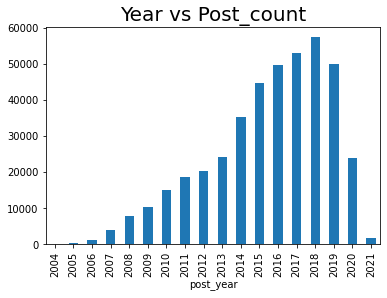

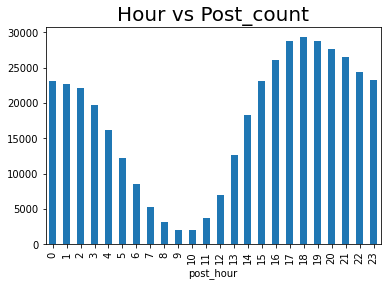

In [120]:
# Looking trend of yelp reviews by year/time
# year/post_count
plt.figure
yelp_coffee_filtered.groupby('post_year')['text'].count().plot.bar()
plt.title('Year vs Post_count',fontsize=20)
plt.show()
# hour/post_count
plt.figure
yelp_coffee_filtered.groupby('post_hour')['text'].count().plot.bar()
plt.title('Hour vs Post_count',fontsize=20)
plt.show()

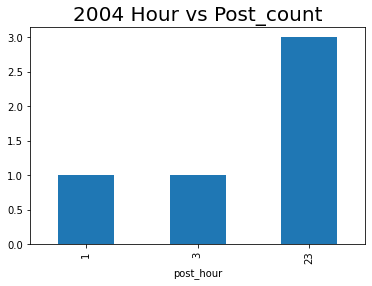

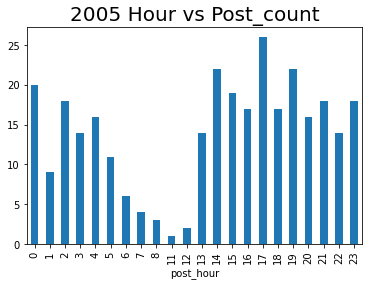

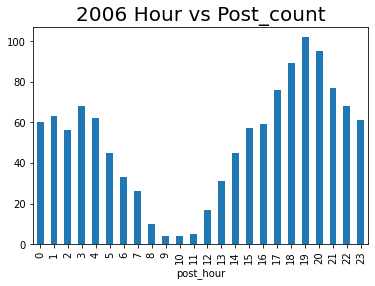

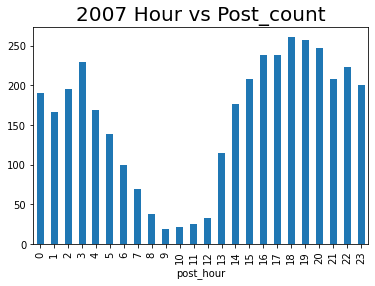

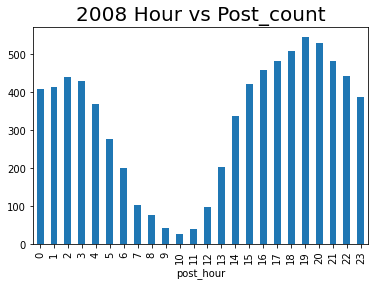

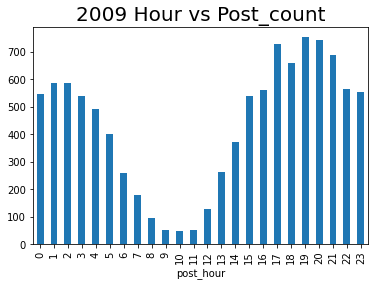

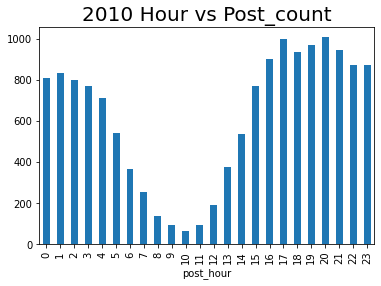

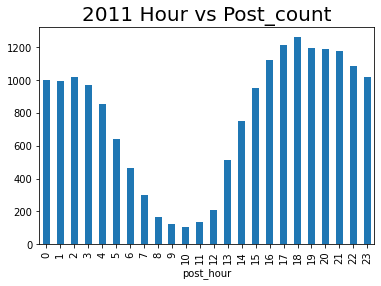

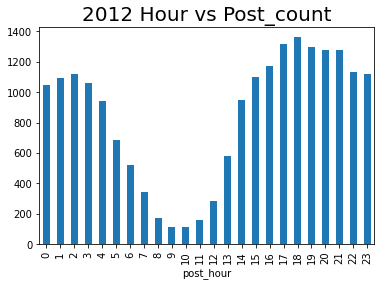

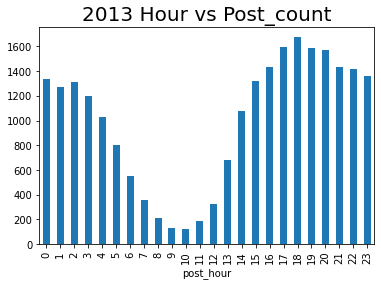

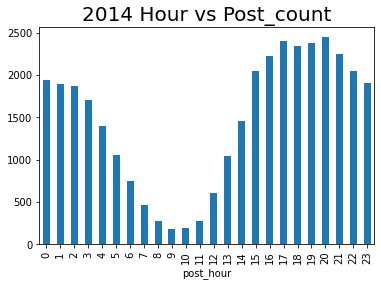

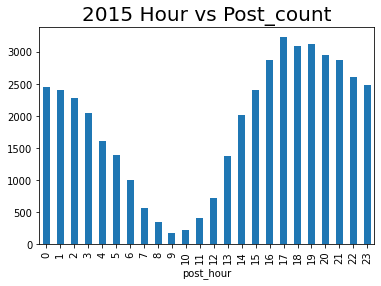

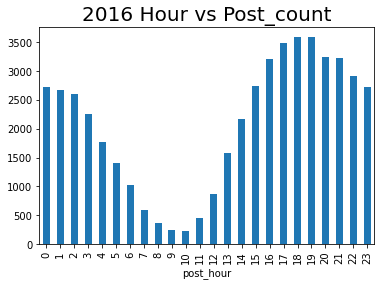

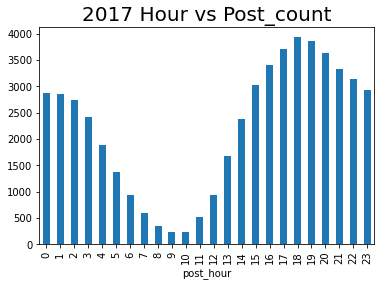

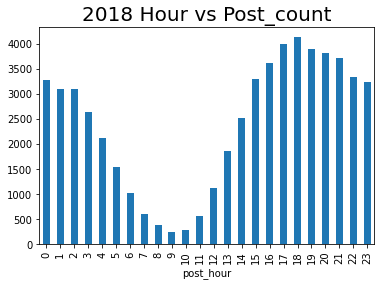

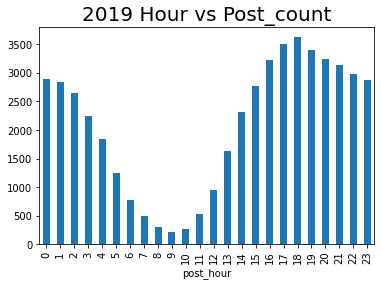

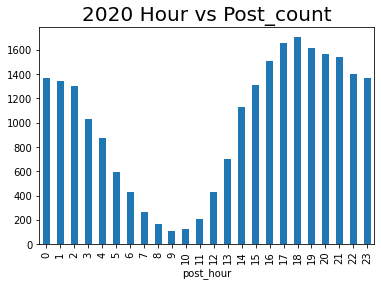

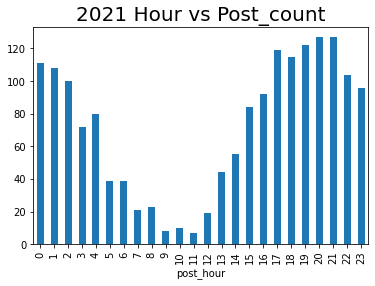

In [119]:
# year, hour/post_count
yr_hr_post = yelp_coffee_filtered.groupby(['post_year', 'post_hour'])['text'].count()
for year in list(np.sort(yelp_coffee_filtered['post_year'].unique())):
    plt.figure()
    yr_hr_post.loc[year,].plot.bar()
    plt.title('{} Hour vs Post_count'.format(year), fontsize=20)
    plt.show()

Looks like the reviews keep growing since 2010, and got a shock at 2020, since the covid19 pandemic.  
And there's no different pattern with hour, most of the reviews are posted at night to midnight.

### Let's start to deal with text content

In [95]:
# Check how many reviews are not tokenized
print('Total reviews: ', yelp_coffee_filtered.shape[0])
print('Tokenized reviews: ', yelp_coffee_filtered[yelp_coffee_filtered['text_token'].str.len() != 0].shape[0])

Total reviews:  416113
Tokenized reviews:  416083


In [122]:
# Take a look at those not tokenized
yelp_coffee_filtered[yelp_coffee_filtered['text_token'].str.len() == 0][['rv_stars','text','text_token']]

,rv_stars,text,text_token
12488,4,Not the best but the best take out .... That was good!,[]
18464,3,.,[]
59748,5,Love the Taro milk tea so much!!!,[]
65820,4,i like bc it has cafe au lait.,[]
99787,5,。Ama！。,[]
115536,5,THE best Pho I've ever had. 'Nuff Said.,[]
140631,4,.,[]
212619,5,YES!!!,[]
215545,2,eh,[]
221481,5,best cafe au lait in town.enough said.,[]


In [97]:
# Take a look at those tokenized
yelp_coffee_filtered[['text','text_token']].head(10)

,text,text_token
0,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.,"[great, coffee, pastry, baristas, excellent, staff, sooooo, vacant]"
1,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.,"[incredible, donut, sometimes, early, selection, donut, never, disappoint]"
2,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!","[bother, go, voodoo, instead, unique, flavor, everything, fresh]"
4,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!","[crazy, establishment, coast, review, place, coast, extremely, fascinating, people, would, passionate, coast, proven, recommend, brunch, needless, whomever, genius, fresh, brunch, delicious, infuse, vodka, awesome, buttermilk, biscuit, order, potato, cake, scramble, delicious, sausage, gross, cover, grease, top, choice, bacon, gravy, mushroom, rosemary, gravy, personally, chose, mushroom, rosemary, gravy, think, hand, gravy, try, might, lick, entire, plate, look, finished, flavor, right, shock, greasiness, usual, breakfast, food, perfectly, prepare, dish, like, lastly, order, biscuit, heaven, bake, enjoyment, savor]"
5,"5 stars for the location, it's absolutely wonderful. I ordered the shamrock bubble tea, which was one of the best I've ever had. I am subtracting a star for service however. It was the barista that was so put out by waiting on us and then the 10-15 minutes it took to make the bubble tea... That's a bit long for a drink.","[star, location, absolutely, wonderful, order, shamrock, bubble, subtract, service, however, barista, wait, minute, bubble, drink]"
7,"Falafel wrap - falafel with greens, pickles, and hummus in a toasted wrap. I wonder why the reviews were so low. I entered without looking at yelp initially but then after checking in and seeing the amount of stars I kind of grew the assumption that it wasn't going to be good. But it was really good. This was probably the best falafel wrap I ever had. They pressed the wrap too so it has a nice crunch but still soft to chew. The falafels weren't bland and each bite tasted the same, which makes wraps great, since it's evenly disturbed. \n\nThey are far from cheap on the stuffing so eat up! The wait time wasn't long during their busy time and it's a good portion for a hungry person, so I suggest checking this place out.","[falafel, falafel, green, pickle, hummus, toast, wonder, review, enter, without, look, initially, check, see, amount, star, assumption, go, really, probably, falafel, press, crunch, still, falafels, bland, taste, make, wrap, great, since, evenly, disturb, cheap, stuff, portion, hungry, person, suggest, check, place]"
8,"If this isn't your first time at the specialty coffee rodeo and if you know you're way around a pour over, burr gr

In [98]:
# Create dictionary via gensim
dictionary = corpora.Dictionary(yelp_coffee_filtered['text_token'].to_list())
# Creating corpus
corpus = [dictionary.doc2bow(text) for text in yelp_coffee_filtered['text_token'].to_list()]

In [99]:
# Save the dictionary
pickle.dump(corpus,open('corpus.pkl','wb'))
dictionary.save('dictionary.gensim')

In [100]:
# Using LDA find 10 topics
NUM_TOPICS = 10
# Use 'LdaMulticore(workers=n)' in multicore environment to speed up training.
# Tune the model with parameters alpha (A-priori belief on document-topic distribution, default=’symmetric’) 
# and eta (A-priori belief on topic-word distribution, default=’symmetric’).
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes=15)
# Save the model
ldamodel.save('10topics/yelp_topics.gensim')

In [101]:
# Top 5 words in each topic
topics = ldamodel.print_topics(num_words = 5)
# Take a look at each topic
for topic in topics:
    print(topic)

(0, '0.026*"chicken" + 0.024*"toast" + 0.022*"cheese" + 0.022*"breakfast" + 0.019*"sauce"')
(1, '0.066*"donut" + 0.025*"doughnut" + 0.018*"flavor" + 0.014*"blueberry" + 0.012*"cinnamon"')
(2, '0.010*"store" + 0.010*"business" + 0.010*"customer" + 0.010*"people" + 0.009*"thing"')
(3, '0.038*"seat" + 0.035*"table" + 0.031*"park" + 0.024*"bagel" + 0.023*"inside"')
(4, '0.026*"place" + 0.020*"drink" + 0.017*"taste" + 0.016*"really" + 0.014*"flavor"')
(5, '0.048*"cream" + 0.037*"chocolate" + 0.025*"flavor" + 0.023*"sweet" + 0.021*"pastry"')
(6, '0.041*"order" + 0.019*"service" + 0.018*"would" + 0.016*"place" + 0.013*"minute"')
(7, '0.119*"coffee" + 0.030*"place" + 0.022*"latte" + 0.018*"drink" + 0.016*"great"')
(8, '0.066*"great" + 0.056*"place" + 0.034*"friendly" + 0.033*"service" + 0.030*"staff"')
(9, '0.132*"sandwich" + 0.034*"breakfast" + 0.032*"bread" + 0.031*"vegan" + 0.024*"lunch"')


In [12]:
# Visualize the result
%matplotlib inline
pyLDAvis.enable_notebook()
lda_display = gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

C:\Users\user\Anaconda3\envs\py3.9\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
# Save the result
pyLDAvis.save_html(lda_display, '10topics/10_topics_result.html')

In [10]:
# Load the model and dict
with open('corpus.pkl','rb') as f:
    corpus = pickle.load(f)
dictionary = corpora.Dictionary.load('dictionary.gensim')
ldamodel = gensim.models.ldamodel.LdaModel.load('10topics/yelp_topics.gensim')

In [103]:
# Let's get the most possible topic of each review
from operator import itemgetter
yelp_coffee_filtered['topic_10'] = yelp_coffee_filtered['text_token'].map(
    lambda text:max(ldamodel.get_document_topics(dictionary.doc2bow(text)), key = itemgetter(1))[0])

C:\Users\user\AppData\Local\Temp/ipykernel_20792/2673216804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_coffee_filtered['topic_10'] = yelp_coffee_filtered['text_token'].map(


In [107]:
# Let's see the relationship between topics and stars
star_topic_count = yelp_coffee_filtered.groupby(['rv_stars','topic_10'])['text_token'].count()

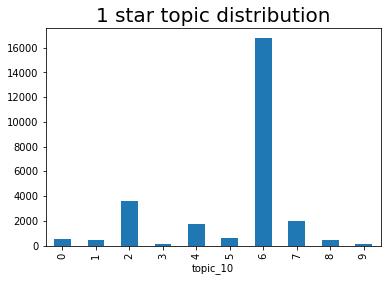

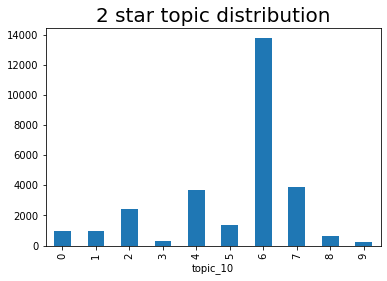

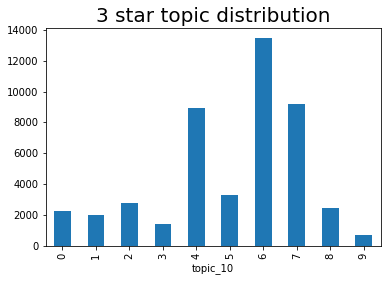

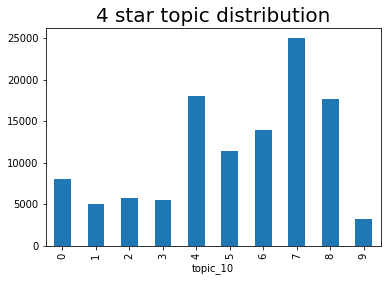

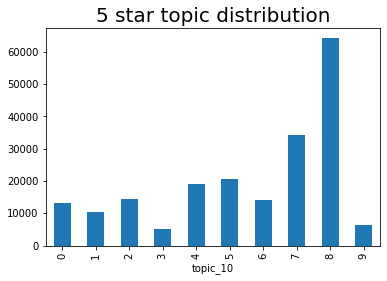

In [141]:
# Visualize the result
for star in list(np.sort(yelp_coffee_filtered['rv_stars'].unique())):
    plt.figure()
    star_topic_count.loc[star,].plot.bar()
    plt.title('{} star topic distribution'.format(star), fontsize=20)
    plt.show()

We can see that the low star reviews (<=3☆) mainly focus on topic 6.  
And topic 4, 7 and 8 appear more in high star reviews (>=4☆).  
Now, we can go back to previous cell to check what are these topics.

Topic 6 got words like order, service, minute, wait, ask, arrive in it, so we can guess that it is about issue of waiting meals to be served.    
Topic 4 got words like bubble, matcha, drink, green, curry in it, so we can guess that it is about drinks other than coffee, or maybe some asian style of the store.  
Topic 7 got words like coffee, latte, espresso in it, so we can guess that it is about coffee's quality.  
We are hard to find what's about topic 8, since it gots words like friendly, helpful, great in it, but it does appear words like hookah, pricing, mask, covid19 in it, so maybe it is about constraint of the store? Not sure about it.  


Therefore we suggest that:  
1. The new store should watch out for the delivery speed of meals to avoid bad reviews.  
2. The new store can also sell drinks like bubble tea or matcha, since people give good review for that.  
3. The new store should still focus on the quality of coffee, since people do care and leave reviews about it.


In [142]:
# Let's try out more topics, this can make each topic more precise
# Using LDA find 30 topics
NUM_TOPICS = 30
ldamodel_30 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes=15)
# Save the model
ldamodel_30.save('30topics/yelp_topics_30.gensim')

In [143]:
# Top 5 words in each topic
topics_30 = ldamodel_30.print_topics(num_words = 5)
# Take a look at each topic
for topic in topics_30:
    print(topic)

(0, '0.293*"cream" + 0.174*"flavor" + 0.024*"coconut" + 0.021*"creamy" + 0.020*"taste"')
(15, '0.266*"sandwich" + 0.083*"salad" + 0.072*"lunch" + 0.067*"bread" + 0.042*"cheese"')
(16, '0.112*"staff" + 0.095*"friendly" + 0.088*"always" + 0.056*"place" + 0.052*"great"')
(29, '0.195*"chocolate" + 0.039*"whole" + 0.038*"sample" + 0.038*"white" + 0.033*"cheesecake"')
(23, '0.118*"cupcake" + 0.099*"good" + 0.082*"bake" + 0.047*"cookie" + 0.039*"cooky"')
(25, '0.089*"chicken" + 0.059*"sauce" + 0.043*"pizza" + 0.040*"fry" + 0.025*"restaurant"')
(19, '0.100*"breakfast" + 0.047*"toast" + 0.040*"brunch" + 0.032*"bacon" + 0.032*"biscuit"')
(7, '0.211*"donut" + 0.038*"apple" + 0.035*"bacon" + 0.035*"donuts" + 0.031*"fritter"')
(17, '0.165*"great" + 0.138*"service" + 0.045*"excellent" + 0.040*"price" + 0.039*"place"')
(22, '0.052*"crepe" + 0.052*"store" + 0.042*"portland" + 0.017*"selection" + 0.015*"visit"')
(2, '0.276*"option" + 0.160*"vegan" + 0.059*"gluten" + 0.038*"beer" + 0.035*"grit"')
(5, '0

In [9]:
# Visualize the result
%matplotlib inline
pyLDAvis.enable_notebook()
lda_display = gensim_models.prepare(ldamodel_30, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

In [ ]:
# Save the result
pyLDAvis.save_html(lda_display, '30topics/30_topics_result.html')

In [4]:
# Load the model and dict
with open('corpus.pkl','rb') as f:
    corpus = pickle.load(f)
dictionary = corpora.Dictionary.load('dictionary.gensim')
ldamodel_30 = gensim.models.ldamodel.LdaModel.load('30topics/yelp_topics_30.gensim')

2022-02-10 17:35:45.796 INFO    gensim.utils: loading Dictionary object from dictionary.gensim
2022-02-10 17:35:45.866 INFO    gensim.utils: Dictionary lifecycle event {'fname': 'dictionary.gensim', 'datetime': '2022-02-10T17:35:45.865246', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}
2022-02-10 17:35:45.866 INFO    gensim.utils: loading LdaModel object from 30topics/yelp_topics_30.gensim
2022-02-10 17:35:45.871 INFO    gensim.utils: loading expElogbeta from 30topics/yelp_topics_30.gensim.expElogbeta.npy with mmap=None
2022-02-10 17:35:45.896 INFO    gensim.utils: setting ignored attribute dispatcher to None
2022-02-10 17:35:45.897 INFO    gensim.utils: setting ignored attribute state to None
2022-02-10 17:35:45.898 INFO    gensim.utils: setting ignored attribute id2word to None
2022-02-10 17:35:45.898 INFO    gensim.utils: LdaModel lifecycle event {'fname': '30topics/yelp_

In [151]:
# Let's get the most possible topic of each review
from operator import itemgetter
yelp_coffee_filtered['topic_30'] = yelp_coffee_filtered['text_token'].map(
    lambda text:max(ldamodel_30.get_document_topics(dictionary.doc2bow(text)), key = itemgetter(1))[0])

C:\Users\user\AppData\Local\Temp/ipykernel_20792/3902409260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_coffee_filtered['topic_30'] = yelp_coffee_filtered['text_token'].map(


In [121]:
# Save the result
yelp_coffee_filtered.to_pickle('yelp_coffee_topic.pkl')

In [154]:
# Let's see the relationship between topics and stars
star_topic30_count = yelp_coffee_filtered.groupby(['rv_stars','topic_30'])['text_token'].count()

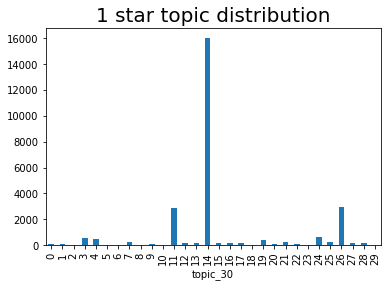

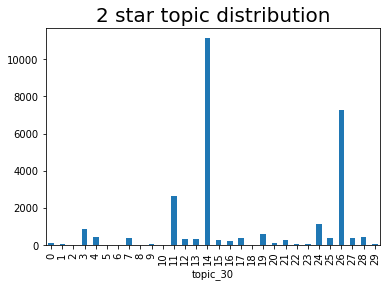

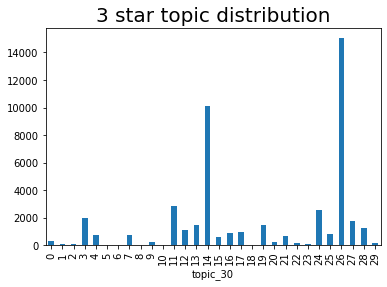

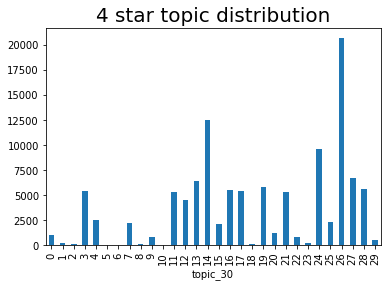

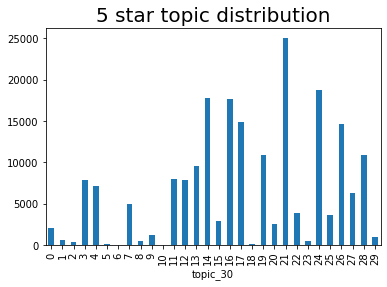

In [155]:
# Visualize the result
for star in list(np.sort(yelp_coffee_filtered['rv_stars'].unique())):
    plt.figure()
    star_topic30_count.loc[star,].plot.bar()
    plt.title('{} star topic distribution'.format(star), fontsize=20)
    plt.show()

We can see that the low star reviews (<=3☆) mainly focus on topic 11, 14, 26.  
And topic 21 and 24 appear more in high star reviews (>=4☆).  
Now, we can go back to previous cell to check what are these topics.

Topic 11 is mainly about order and server, so we can guess that it is complaining about the speed and waiting.    
Topic 14 is also about order and service, so we can guess that it is similar to topic 11.  
Topic 26 is mainly about expensive, we can't guess that it is complaining about the price.  
Topic 21 is about bagel, so maybe it is a good idea to sell some light meal along with coffee.  
Topic 24 is mainly about coffee, so the quality of coffee itself does important.  


Therefore we suggest that:  
1. The new store should watch out for the price, people do care about it and will leave bad reviews for that.  
2. If the new store are going to sell meals, make sure it serve on time, people hate to wait long time and will leave bad reviews for it.  
3. The new store should still focus on the quality of coffee, since people do care and leave good reviews about it.  
4. It is a good idea to sell light meal along with coffee, people love it and leave good reviews for that.
